# Lab-customer-analysis-final-round

### 1. Problem (case study)

KPI: Can we predict the amount claimed by a client?

### 2. Getting Data

In [1]:

# Relevant Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from scipy.special import inv_boxcox

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the .csv file
data=pd.read_csv('../lab-customer-analysis-final-round/files_for_lab/csv_files/marketing_customer_analysis.csv')

### 3. Cleaning/Wrangling/EDA

In [3]:
# Change headers names
data.columns=[e.lower().replace(' ', '_') for e in data.columns]   # lower and replace
data.columns

Index(['customer', 'state', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'employmentstatus', 'gender',
       'income', 'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size'],
      dtype='object')

In [4]:
# Deal with NaN values
data.isna().sum()     # missing values

customer                         0
state                            0
customer_lifetime_value          0
response                         0
coverage                         0
education                        0
effective_to_date                0
employmentstatus                 0
gender                           0
income                           0
location_code                    0
marital_status                   0
monthly_premium_auto             0
months_since_last_claim          0
months_since_policy_inception    0
number_of_open_complaints        0
number_of_policies               0
policy_type                      0
policy                           0
renew_offer_type                 0
sales_channel                    0
total_claim_amount               0
vehicle_class                    0
vehicle_size                     0
dtype: int64

In [5]:
data=data.drop(columns=['vehicle_class', 'customer'])   # drop useless columns

In [6]:
data=data.dropna()   # drop rows with nan values

In [7]:
for c in data.columns.tolist():         # know the unique values for each column
    print(c, len(data[c].unique()))

state 5
customer_lifetime_value 8041
response 2
coverage 3
education 5
effective_to_date 59
employmentstatus 5
gender 2
income 5694
location_code 3
marital_status 3
monthly_premium_auto 202
months_since_last_claim 36
months_since_policy_inception 100
number_of_open_complaints 6
number_of_policies 9
policy_type 3
policy 9
renew_offer_type 4
sales_channel 4
total_claim_amount 5106
vehicle_size 3


In [8]:
data.shape

(9134, 22)

In [9]:
print('Original dtype: {}\n'.format(data['effective_to_date'].dtype))   # object
data['effective_to_date']=pd.to_datetime(data['effective_to_date'])   # datetime
print('Meantime dtype: {}'.format(data['effective_to_date'].dtype))

Original dtype: object

Meantime dtype: datetime64[ns]


In [10]:
print('--')
print('Min date: {}'.format(data['effective_to_date'].min()))         # from January 1st..
print('Max date: {}'.format(data['effective_to_date'].max()))         # to February 28th
print('--')

--
Min date: 2011-01-01 00:00:00
Max date: 2011-02-28 00:00:00
--


In [11]:
data['effective_to_date']=data['effective_to_date'].apply(lambda x: x.toordinal())   # you can change the type to ordinal.

print('New dtype: {}'.format(data['effective_to_date'].dtype))

New dtype: int64


In [12]:
# Values for each class in categorical features
cat_cols=[col for col in data.columns if (data[col].dtype==object)]     # categorical columns

print('Categorical Features:', len(cat_cols))
print('----------')
for c in cat_cols:
    print('Name: {}'.format(data[c].name))    # column name
    print('Type: {}'.format(data[c].dtype))   # column type
    print('Unique values: {}'.format(len(data[c].unique())))   # column unique values
    print(data[c].unique())
    print(((data[c].value_counts()/ sum(data[c].value_counts()))*100))   # percentage
    print('\n----------')

Categorical Features: 13
----------
Name: state
Type: object
Unique values: 5
['Washington' 'Arizona' 'Nevada' 'California' 'Oregon']
California    34.486534
Oregon        28.476024
Arizona       18.644624
Nevada         9.656229
Washington     8.736589
Name: state, dtype: float64

----------
Name: response
Type: object
Unique values: 2
['No' 'Yes']
No     85.679877
Yes    14.320123
Name: response, dtype: float64

----------
Name: coverage
Type: object
Unique values: 3
['Basic' 'Extended' 'Premium']
Basic       60.959054
Extended    30.019707
Premium      9.021239
Name: coverage, dtype: float64

----------
Name: education
Type: object
Unique values: 5
['Bachelor' 'College' 'Master' 'High School or Below' 'Doctor']
Bachelor                30.085395
College                 29.351872
High School or Below    28.705934
Master                   8.112547
Doctor                   3.744252
Name: education, dtype: float64

----------
Name: employmentstatus
Type: object
Unique values: 5
['Employe

In [13]:
# Numerical Features
data.describe()

customer_lifetime_value  effective_to_date        income  \
count              9134.000000        9134.000000   9134.000000   
mean               8004.940475      734166.837749  37657.380009   
std                6870.967608          16.942769  30379.904734   
min                1898.007675      734138.000000      0.000000   
25%                3994.251794      734152.000000      0.000000   
50%                5780.182197      734166.000000  33889.500000   
75%                8962.167041      734181.000000  62320.000000   
max               83325.381190      734196.000000  99981.000000   

       monthly_premium_auto  months_since_last_claim  \
count           9134.000000              9134.000000   
mean              93.219291                15.097000   
std               34.407967                10.073257   
min               61.000000                 0.000000   
25%               68.000000                 6.000000   
50%               83.000000                14.000000   
75%              109.000000                23.000000   
max              298.000000                35.000000   

       months_since_policy_inception  number_of_open_complaints  \
count                    9134.000000                9134.000000   
mean                       48.064594                   0.384388   
std                        27.905991                   0.910384   
min                         0.000000                   0.000000   
25%                        24.000000                   0.000000   
50%                        48.000000                   0.000000   
75%                        71.000000                   0.000000   
max                        99.000000                   5.000000   

       number_of_policies  total_claim_amount  
count         9134.000000         9134.000000  
mean             2.966170          434.088794  
std              2.390182          290.500092  
min              1.000000            0.099007  
25%              1.000000          272.258244  
50%              2.000000          383.945434  
75%              4.000000          547.514839  
max              9.000000         2893.239678

In [14]:
num_cols=[c for c in data.columns if (data[c].dtype!='object') and (c!='Effective To Date')]   # numerical columns

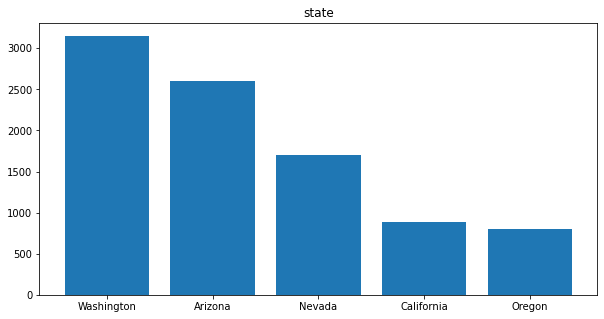

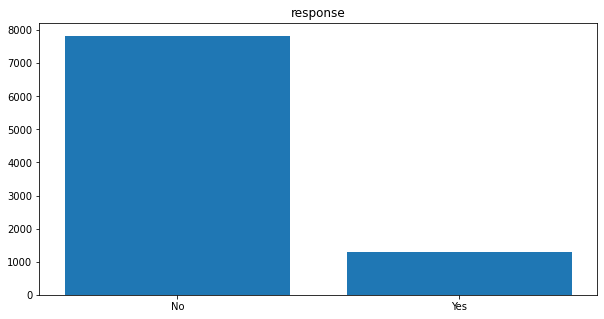

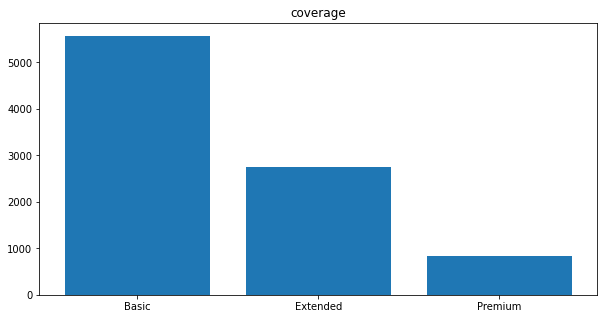

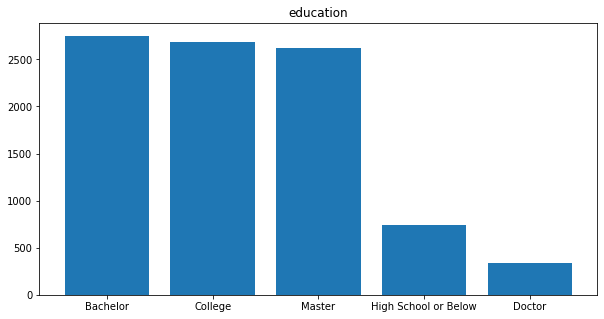

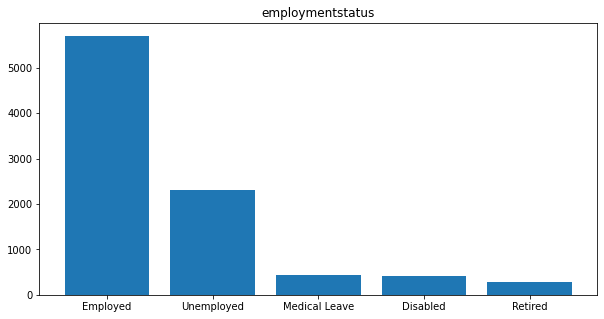

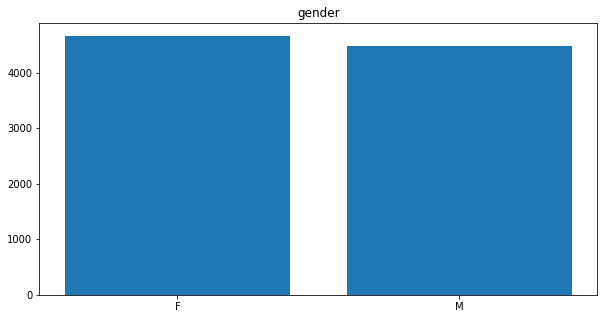

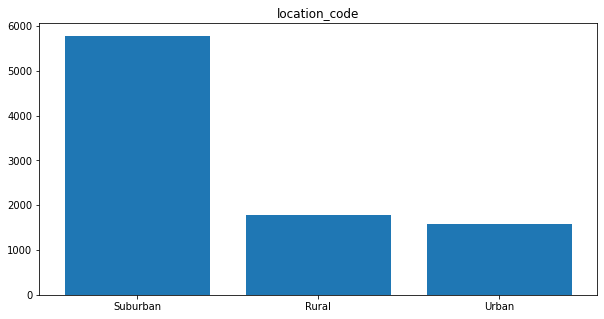

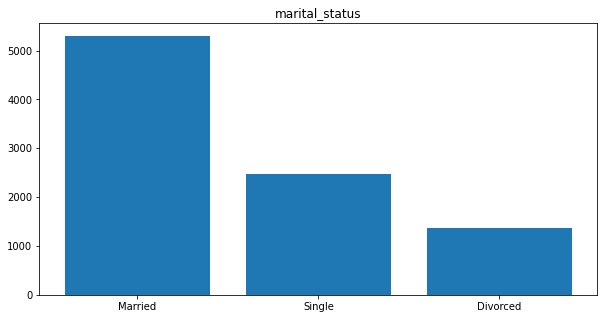

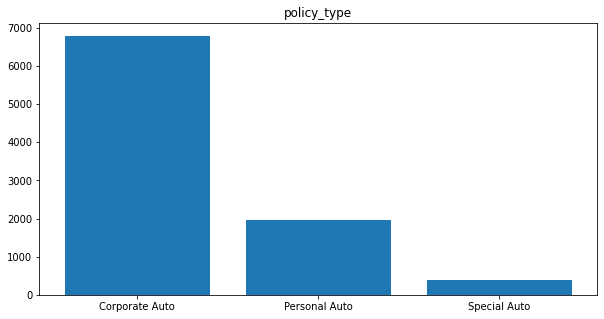

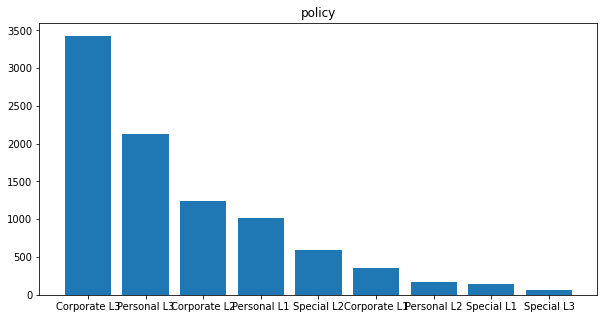

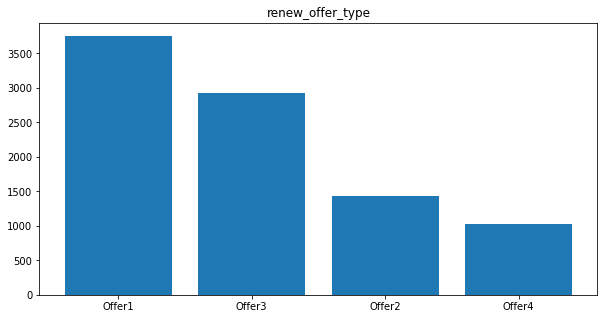

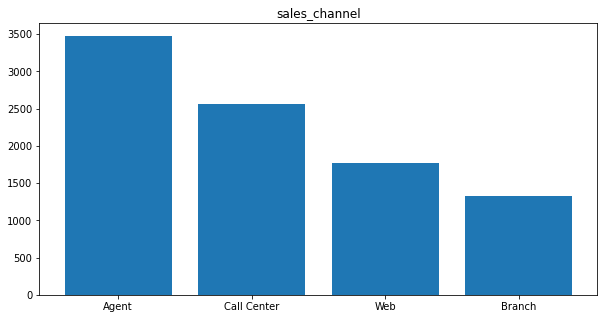

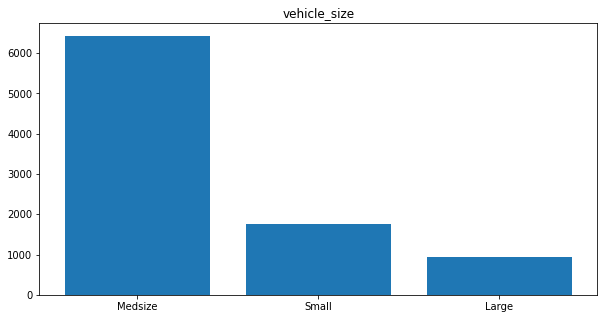

In [15]:
# Exploration
# Bar plot for categorical variables
for c in cat_cols:
    plt.figure(figsize=(10,5))
    plt.bar(data[c].unique(), data[c].value_counts())
    plt.title(c)
    plt.show();

In [16]:
corr=data.corr()      # correlation matrix

In [17]:
# generate a mask 
mask = np.zeros_like(data.corr())
mask

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

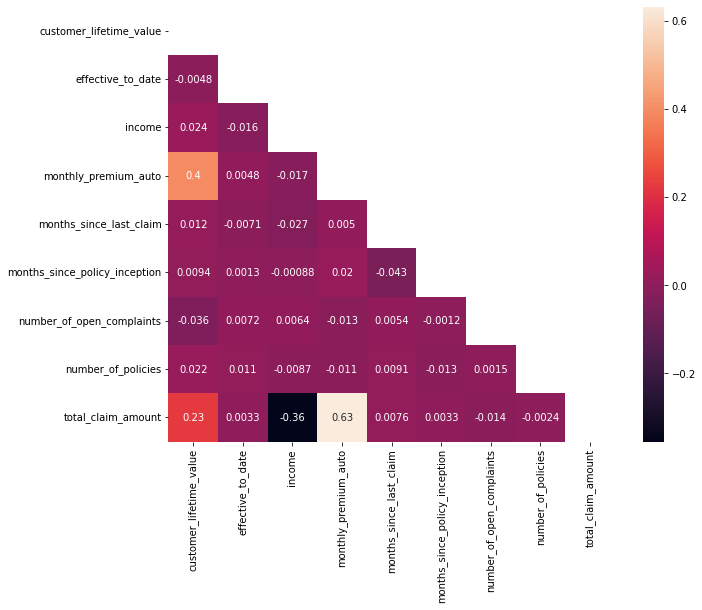

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))                 # heatmap
ax = sns.heatmap(data.corr(), mask=mask, annot=True)
plt.show()

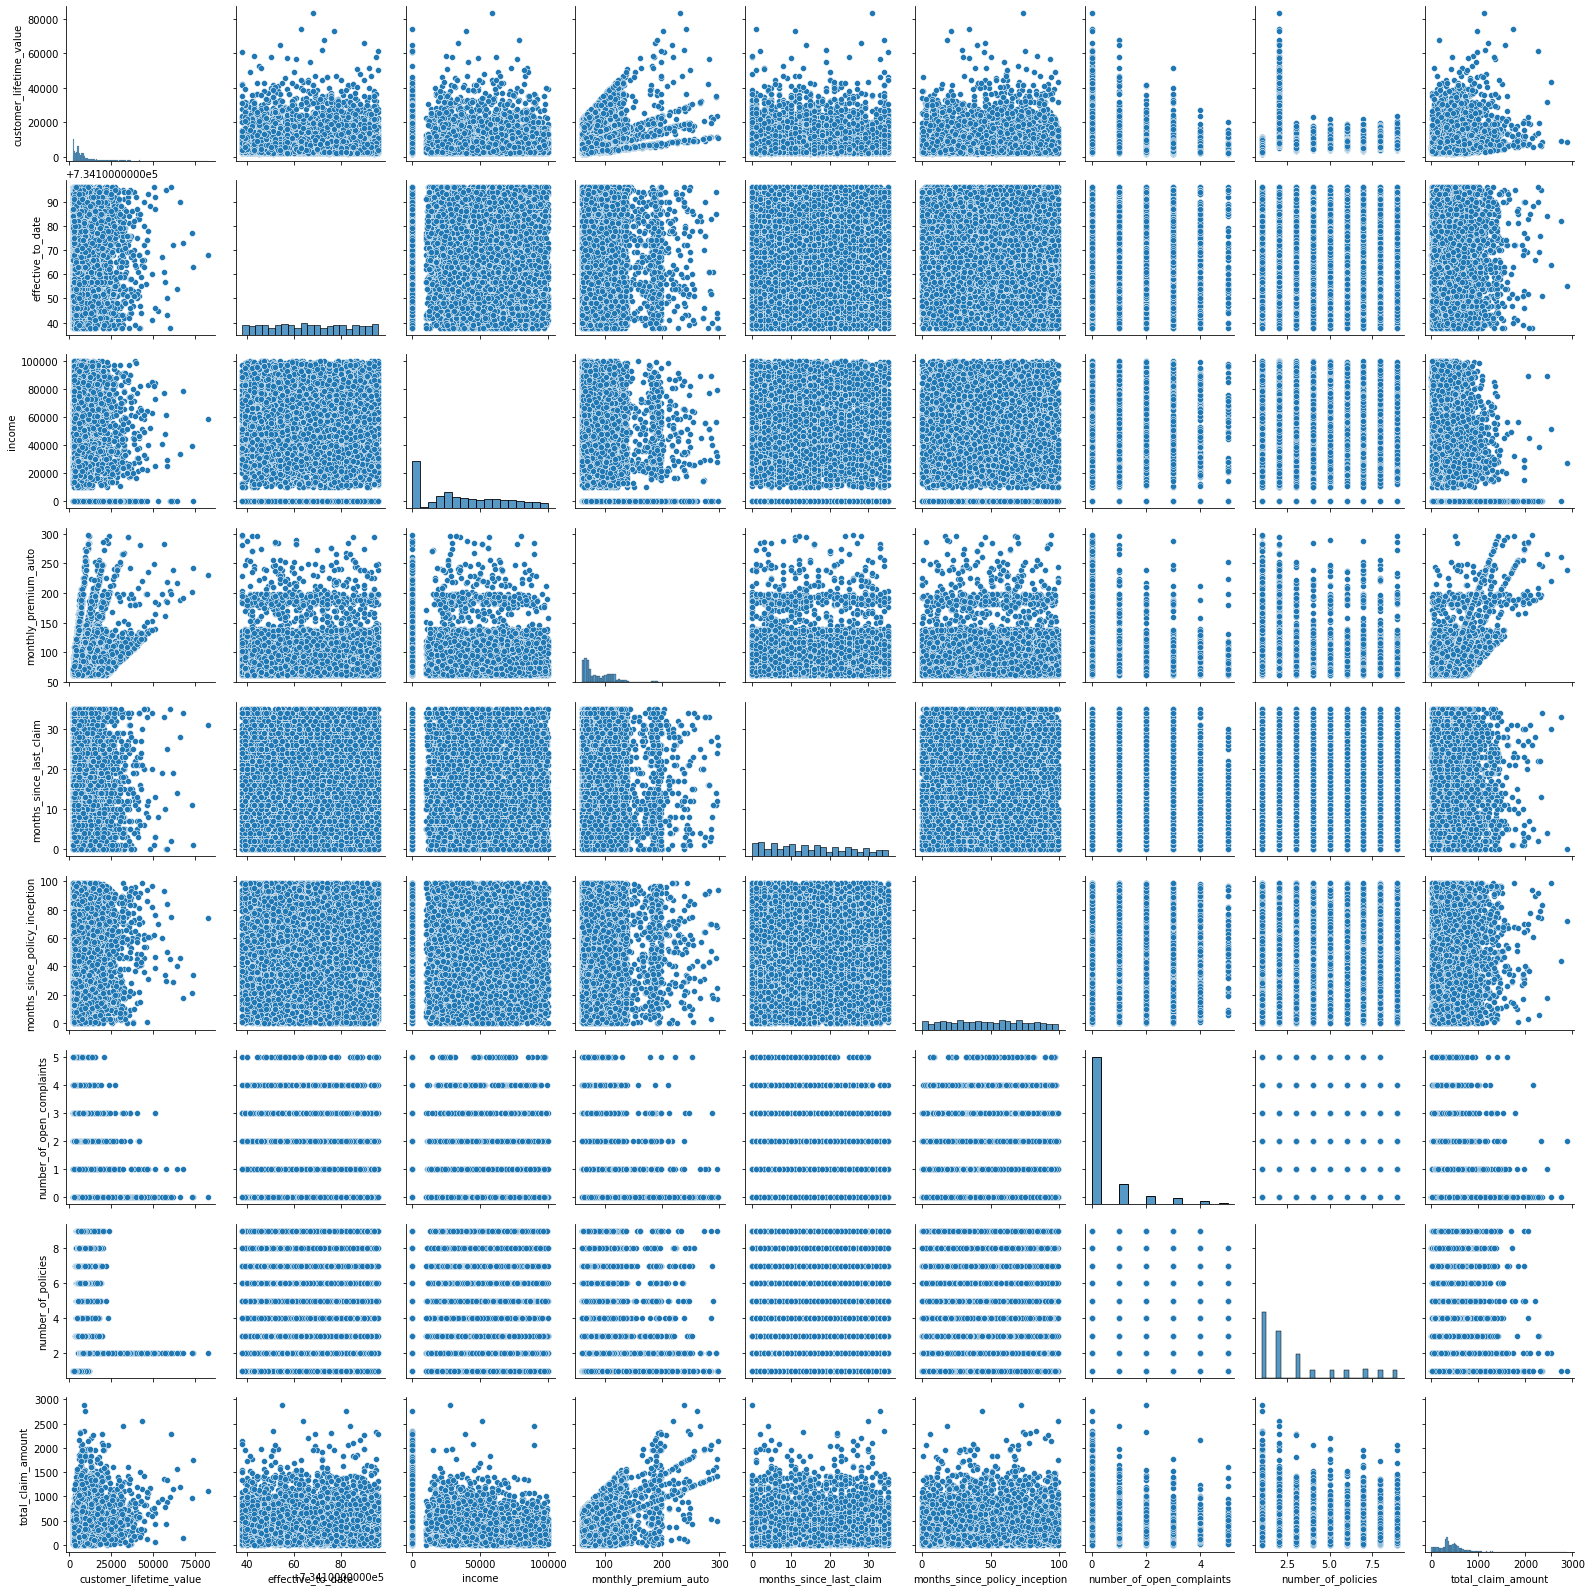

In [20]:
# covariance visualization for all variables
sns.pairplot(data)

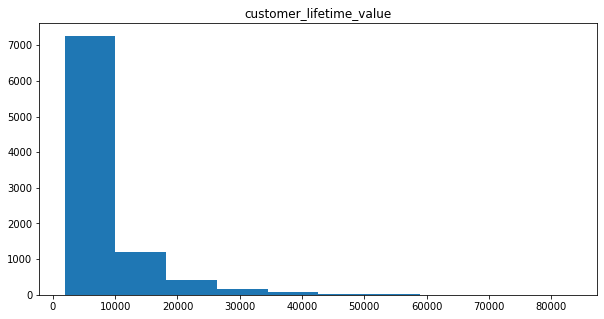

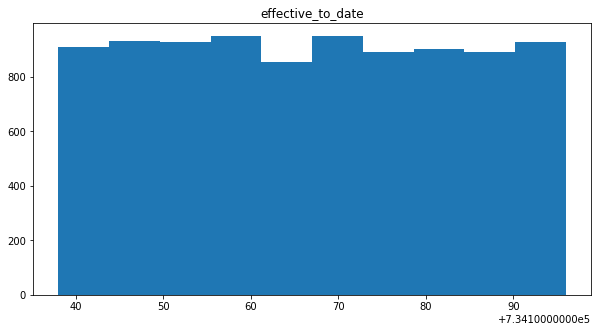

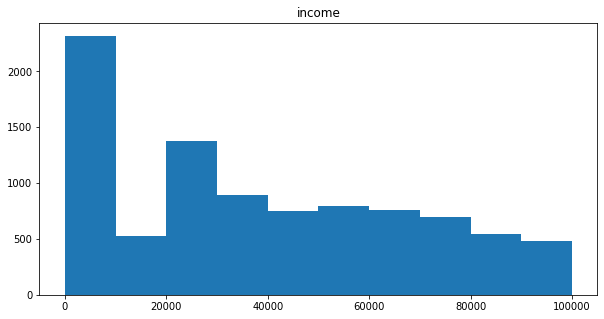

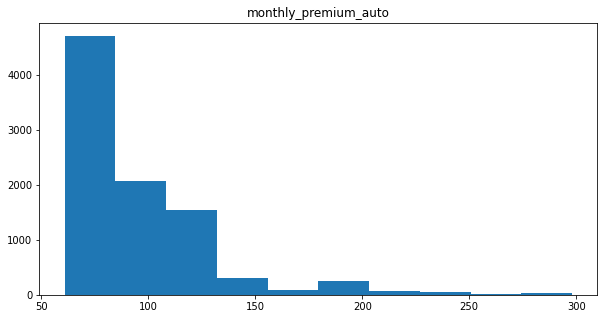

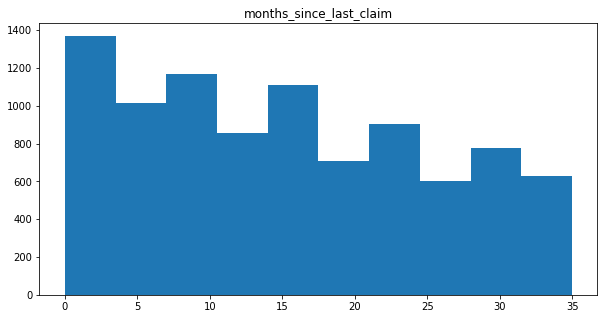

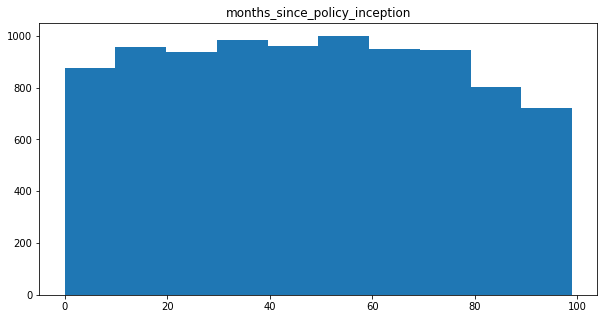

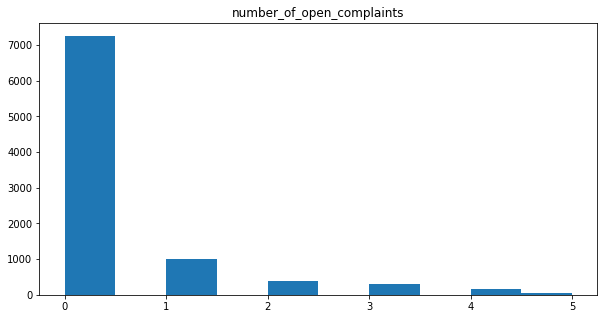

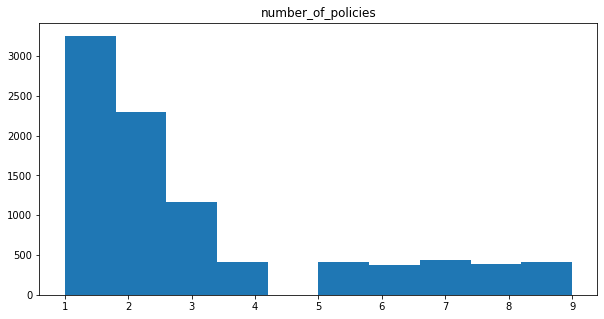

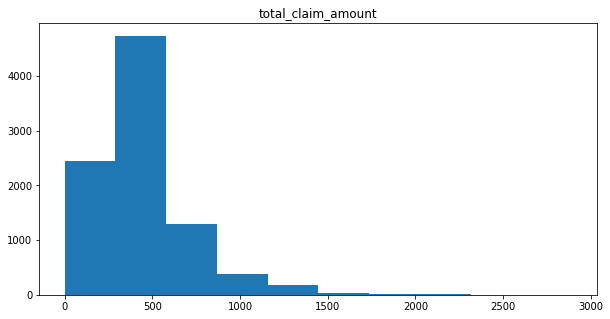

In [21]:
# Bar plot for each numerical variable.

for c in num_cols:
    plt.figure(figsize=(10,5))
    plt.hist(data[c])
    plt.title(c)
    plt.show();

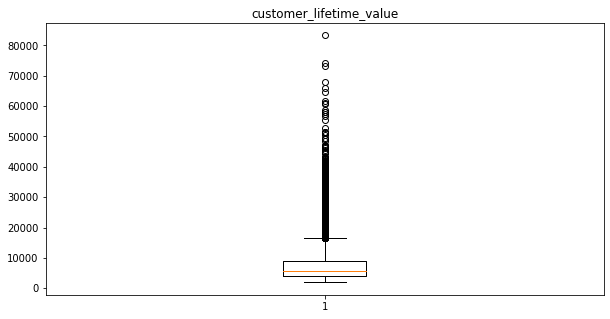

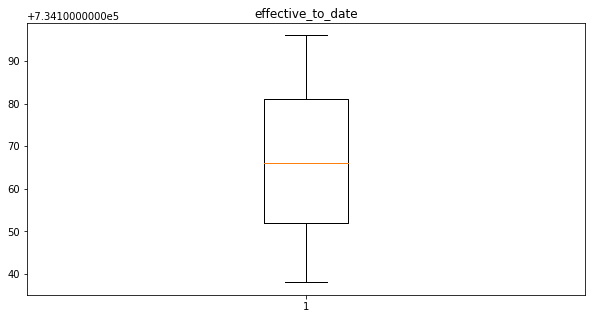

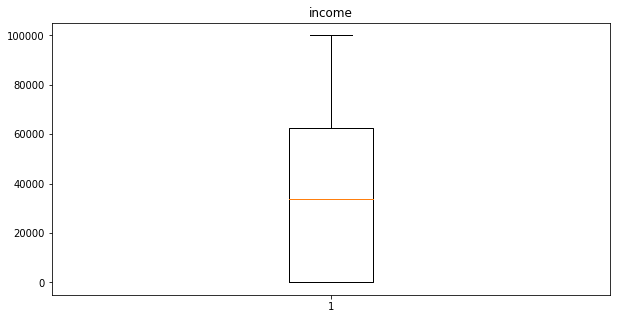

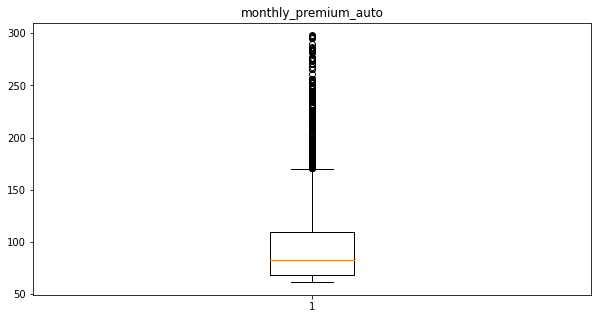

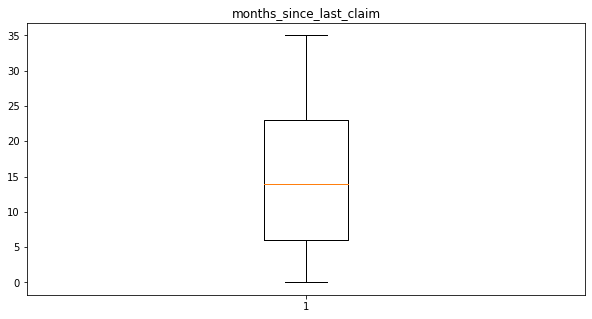

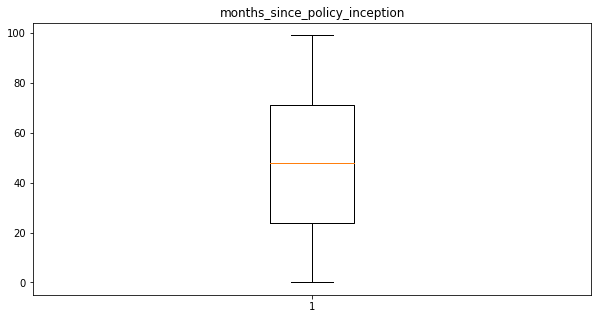

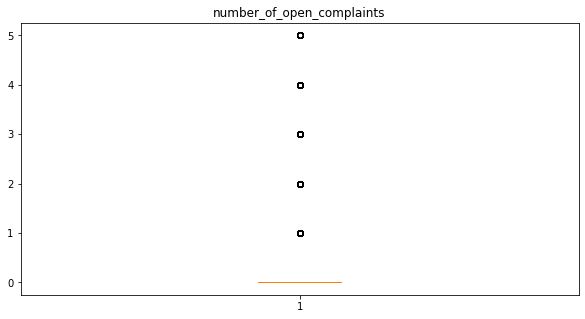

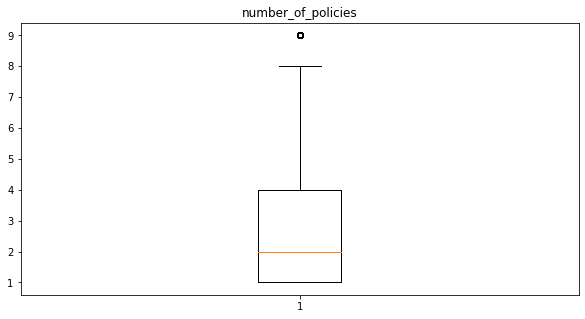

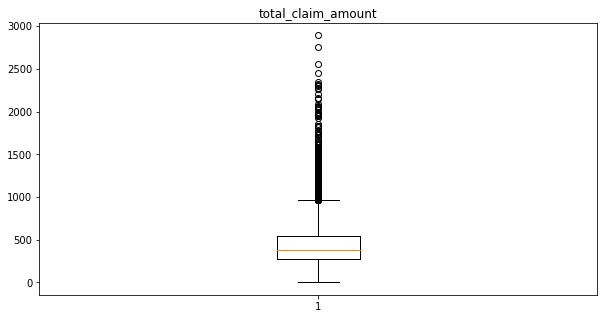

In [22]:
# Box plot for each numerical variable for know outliers of each feature.

for c in num_cols:
    plt.figure(figsize=(10,5))
    plt.boxplot(data[c])
    plt.title(c)
    plt.show();

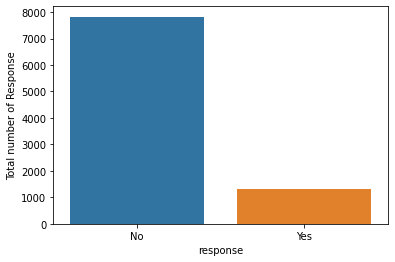

In [23]:
#Show a plot of the total number of response.

sns.countplot('response', data=data)
plt.ylabel('Total number of Response')
plt.show();

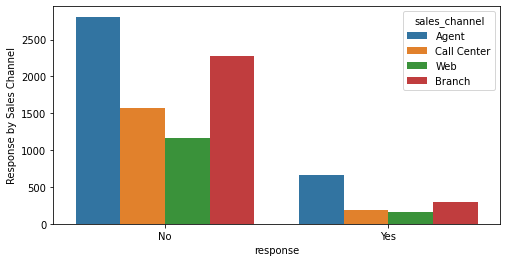

In [24]:
# Show a plot of the response rate by sales channel.

plt.figure(figsize=(8,4))
sns.countplot('response', hue='sales_channel', data=data)
plt.ylabel('Response by Sales Channel')
plt.show();

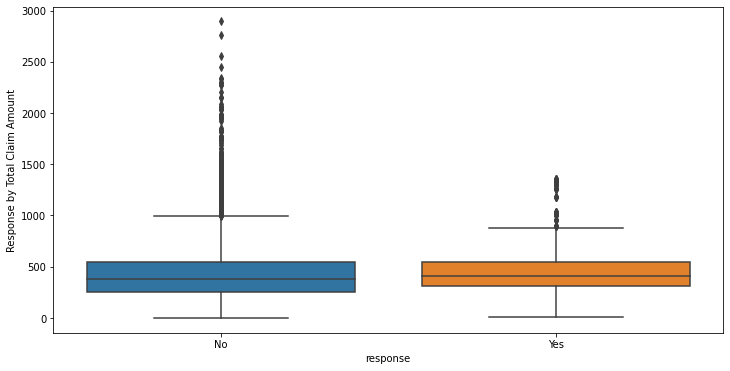

In [25]:
# Show a plot of the response rate by total claim amount.

plt.figure(figsize=(12,6))
sns.boxplot(y='total_claim_amount' , x='response', data=data)
plt.ylabel('Response by Total Claim Amount')
plt.show();

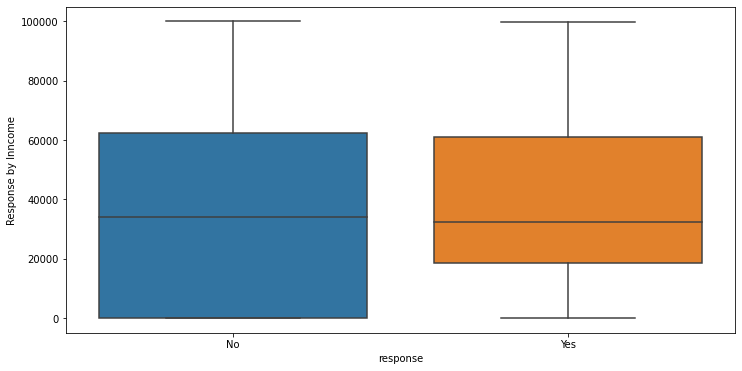

In [26]:
# Show a plot of the response rate by income.

plt.figure(figsize=(12,6))
sns.boxplot(y='income' , x='response', data=data)
plt.ylabel('Response by Inncome')
plt.show();

### 4. Processing Data

In [27]:
# Dealing with outliers
# e.g. 3*IQR in a column

q1=np.percentile(data['customer_lifetime_value'], 25)   # percentile 25
q3=np.percentile(data['customer_lifetime_value'], 75)   # percentile 75

iqr=q3-q1  # IQR

upper=q3+3*iqr   # upper boundary
lower=q1-3*iqr   # lower boundary

In [28]:
len(data[data['customer_lifetime_value']<lower])

0

In [29]:
len(data[data['customer_lifetime_value']>upper])

367

In [30]:
# Normalization
# Min-Max Scaler

data['effective_to_date']=MinMaxScaler().fit_transform(data['effective_to_date'].values.reshape(-1, 1))

data['effective_to_date'].head()

0    0.931034
1    0.517241
2    0.844828
3    0.327586
4    0.568966
Name: effective_to_date, dtype: float64

In [31]:
for c in num_cols[:-1]:   # normalize all less the target column
    data[c]=StandardScaler().fit_transform(data[c].values.reshape(-1, 1))

In [32]:
# Encoding Categorical Data
one_hot_data=pd.get_dummies(data[cat_cols], drop_first=True)   # one hot encoding categorical variables

one_hot_data.head()

state_California  state_Nevada  state_Oregon  state_Washington  \
0                 0             0             0                 1   
1                 0             0             0                 0   
2                 0             1             0                 0   
3                 1             0             0                 0   
4                 0             0             0                 1   

   response_Yes  coverage_Extended  coverage_Premium  education_College  \
0             0                  0                 0                  0   
1             0                  1                 0                  0   
2             0                  0                 1                  0   
3             0                  0                 0                  0   
4             0                  0                 0                  0   

   education_Doctor  education_High School or Below  ...  policy_Special L2  \
0                 0                               0  ...                  0   
1                 0                               0  ...                  0   
2                 0                               0  ...                  0   
3                 0                               0  ...                  0   
4                 0                               0  ...                  0   

   policy_Special L3  renew_offer_type_Offer2  renew_offer_type_Offer3  \
0                  0                        0                        0   
1                  0                        0                        1   
2                  0                        0                        0   
3                  0                        0                        0   
4                  0                        0                        0   

   renew_offer_type_Offer4  sales_channel_Branch  sales_channel_Call Center  \
0                        0                     0                          0   
1                        0                     0                          0   
2                        0                     0                          0   
3                        0                     0                          1   
4                        0                     0                          0   

   sales_channel_Web  vehicle_size_Medsize  vehicle_size_Small  
0                  0                     1                   0  
1                  0                     1                   0  
2                  0                     1                   0  
3                  0                     1                   0  
4                  0                     1                   0  

[5 rows x 38 columns]

In [33]:
# Concat numerical and categorical DataFrames

data=pd.concat([data, one_hot_data], axis=1)   # concat dataframes
data.drop(columns=cat_cols, inplace=True)
data.head()

customer_lifetime_value  effective_to_date    income  monthly_premium_auto  \
0                -0.762878           1.485213  0.612827             -0.703925   
1                -0.149245           0.068602 -1.239617              0.022691   
2                 0.710636           1.190086  0.365710              0.429596   
3                -0.052263          -0.580678 -1.239617              0.371467   
4                -0.755575           0.245679  0.203390             -0.587666   

   months_since_last_claim  months_since_policy_inception  \
0                 1.678099                      -1.543287   
1                -0.208186                      -0.217334   
2                 0.288205                      -0.360680   
3                 0.288205                       0.606907   
4                -0.307465                      -0.145661   

   number_of_open_complaints  number_of_policies  total_claim_amount  \
0                   -0.42225           -0.822648          384.811147   
1                   -0.42225            2.106160         1131.464935   
2                   -0.42225           -0.404247          566.472247   
3                   -0.42225            1.687759          529.881344   
4                   -0.42225           -0.822648          138.130879   

   state_California  ...  policy_Special L2  policy_Special L3  \
0                 0  ...                  0                  0   
1                 0  ...                  0                  0   
2                 0  ...                  0                  0   
3                 1  ...                  0                  0   
4                 0  ...                  0                  0   

   renew_offer_type_Offer2  renew_offer_type_Offer3  renew_offer_type_Offer4  \
0                        0                        0                        0   
1                        0                        1                        0   
2                        0                        0                        0   
3                        0                        0                        0   
4                        0                        0                        0   

   sales_channel_Branch  sales_channel_Call Center  sales_channel_Web  \
0                     0                          0                  0   
1                     0                          0                  0   
2                     0                          0                  0   
3                     0                          1                  0   
4                     0                          0                  0   

   vehicle_size_Medsize  vehicle_size_Small  
0                     1                   0  
1                     1                   0  
2                     1                   0  
3                     1                   0  
4                     1                   0  

[5 rows x 47 columns]

In [34]:
#Splitting into train set and test set
# first, split X-y (learning-target data)
X=data.drop(columns=['total_claim_amount'])
y=data['total_claim_amount']

# checking shape
print(X.shape)
print(y.shape)

(9134, 46)
(9134,)


In [35]:
X_train, X_test, y_train, y_test=tts(X, y, test_size=0.2, random_state=42)  # random state fixed sample

### 5. Modeling

In [36]:
#Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [37]:
predictions = model.predict(X_test)

In [38]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.7634805250557612, 94.65160525863855, 137.13464046274433)

In [39]:
from sklearn.linear_model import Lasso       
from sklearn.linear_model import Ridge      
from sklearn.linear_model import ElasticNet  

In [40]:
# Lasso L1
lasso=Lasso()
lasso.fit(X_train, y_train)

y_pred_lasso=lasso.predict(X_test)

In [41]:
# Ridge L2

ridge=Ridge()
ridge.fit(X_train, y_train)

y_pred_ridge=ridge.predict(X_test)

In [42]:
# ElasticNet L1+L2

elastic=ElasticNet()
elastic.fit(X_train, y_train)

y_pred_elastic=elastic.predict(X_test)

In [43]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor as RFR

rfr=RFR()
rfr.fit(X_train, y_train)

y_pred_rfr=rfr.predict(X_test)

In [45]:
models=[lasso, ridge, elastic, rfr,]
model_names=['lasso', 'ridge', 'elastic', 'rfr']
preds=[y_pred_lasso, y_pred_ridge, y_pred_elastic, y_pred_rfr]

In [46]:
# R2
for i in range(len(models)):

    train_score=models[i].score(X_train, y_train) #R2
    test_score=models[i].score(X_test, y_test)

    print ('Model: {}, train R2: {} -- test R2: {}'.format(model_names[i], train_score, test_score))

Model: lasso, train R2: 0.7711407547712578 -- test R2: 0.7641119521301055
Model: ridge, train R2: 0.7731027163604189 -- test R2: 0.7635042188039316
Model: elastic, train R2: 0.5893935028296453 -- test R2: 0.5734549302778821
Model: rfr, train R2: 0.9782239225699512 -- test R2: 0.8221236239658092


In [48]:
# MSE
from sklearn.metrics import mean_squared_error as mse

for i in range(len(models)):

    train_mse=mse(models[i].predict(X_train), y_train) #MSE
    test_mse=mse(preds[i], y_test)

    print ('Model: {}, train MSE: {} -- test MSE: {}'.format(model_names[i], train_mse, test_mse))

Model: lasso, train MSE: 19579.28482624174 -- test MSE: 18755.7041909956
Model: ridge, train MSE: 19411.43578551831 -- test MSE: 18804.025700269416
Model: elastic, train MSE: 35128.061143295854 -- test MSE: 33915.042428297056
Model: rfr, train MSE: 1862.9792385056485 -- test MSE: 14143.135786615536


In [49]:
# RMSE

for i in range(len(models)):

    train_rmse=mse(models[i].predict(X_train), y_train)**0.5 #RMSE
    test_rmse=mse(preds[i], y_test)**0.5

    print ('Model: {}, train RMSE: {} -- test RMSE: {}'.format(model_names[i], train_rmse, test_rmse))

Model: lasso, train RMSE: 139.92599767820752 -- test RMSE: 136.95146655292012
Model: ridge, train RMSE: 139.32492880141123 -- test RMSE: 137.1277714406145
Model: elastic, train RMSE: 187.42481464122048 -- test RMSE: 184.16037149261254
Model: rfr, train RMSE: 43.16224320520944 -- test RMSE: 118.92491659284667


In [50]:
# MAE
from sklearn.metrics import mean_absolute_error as mae
for i in range(len(models)):
    train_mae=mae(models[i].predict(X_train), y_train) #MAE
    test_mae=mae(preds[i], y_test)

    print ('Model: {}, train MAE: {} -- test MAE: {}'.format(model_names[i], train_mae, test_mae))

Model: lasso, train MAE: 95.57899201990386 -- test MAE: 94.15427425551809
Model: ridge, train MAE: 95.59985058651307 -- test MAE: 94.61696483642022
Model: elastic, train MAE: 126.63591443953064 -- test MAE: 125.83678158992898
Model: rfr, train MAE: 26.92300258975639 -- test MAE: 74.21809680588945


### 6. Conclusion: 

The results show an r-squared of 82% for RandomForestRegressor which reveals that 82% of the data fit the regression model. This high r-squared indicates a good fit for the model.